In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df=pd.read_excel('perrinchampagne.xls',skiprows=11)
df.columns=['Month','Sales']
df=df.set_index('Month')

df.head(5)

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [3]:
df.isna().sum()

Sales    0
dtype: int64

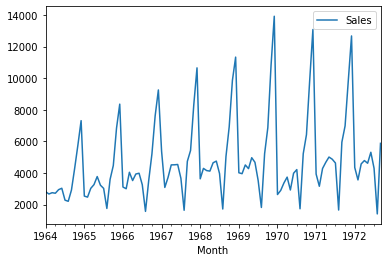

In [4]:
df.plot()

In [5]:
 # Now testing for stationarity
    
from statsmodels.tsa.stattools import adfuller


In [6]:
#HO: it is non-stationary
# H1: it is stationary


def adfuller_test(dataset):
    result= adfuller(dataset, autolag='AIC')
    print("1.ADF Statistics :", result[0])
    print("2.p-value :", result[1])
    print("3.# No of lags used :", result[2])
    print("4. Critical values :")
    
    for  key, val in result[4].items():
        print('Critical value', key , '=', val)  
    
    print('\Statatistical Hypothesis based on P-value')
    if (result[1]<.05):
        print('The data is Stationary its mean that we are \
        rejecting the Ho Hypothesis')
    else:
        print('The data is Non-Stationary, i.e we dont have\
        enough evidence to reject HO hypothesis')
        
    
        
adfuller_test(df['Sales'])
            

1.ADF Statistics : -1.8335930563276228
2.p-value : 0.363915771660245
3.# No of lags used : 11
4. Critical values :
Critical value 1% = -3.502704609582561
Critical value 5% = -2.8931578098779522
Critical value 10% = -2.583636712914788
\Statatistical Hypothesis based on P-value
The data is Non-Stationary, i.e we dont have        enough evidence to reject HO hypothesis


In [7]:
df['Sales First Diff']=df['Sales'].diff(1)

df['Seasonal fist Diff']=df['Sales'].diff(12)
df


,Sales,Sales First Diff,Seasonal fist Diff
Month,,,
1964-01-01,2815,NaN,NaN
1964-02-01,2672,-143.0,NaN
1964-03-01,2755,83.0,NaN
1964-04-01,2721,-34.0,NaN
1964-05-01,2946,225.0,NaN
...,...,...,...
1972-05-01,4618,-170.0,-392.0
1972-06-01,5312,694.0,438.0
1972-07-01,4298,-1014.0,-335.0


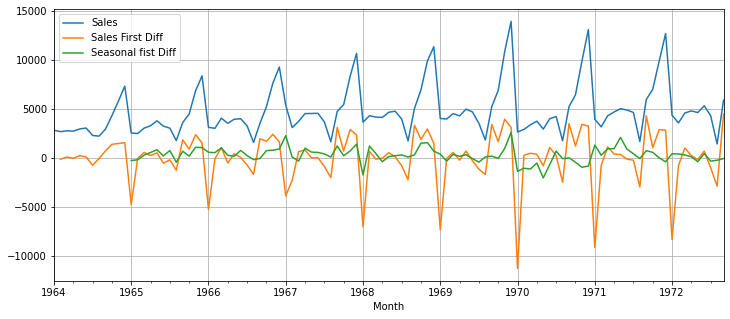

In [8]:
plt.figure(figsize=(12,5))
df['Sales'].plot()
df['Sales First Diff'].plot()
df['Seasonal fist Diff'].plot()
plt.legend()
plt.grid()

In [9]:
# Now checking agin stationarity using adfuller test

print('for Season',adfuller_test(df['Seasonal fist Diff'].dropna()))


# print('For fist diff',adfuller_test(df['Sales First Diff'].dropna()))




1.ADF Statistics : -7.626619157213164
2.p-value : 2.060579696813685e-11
3.# No of lags used : 0
4. Critical values :
Critical value 1% = -3.503514579651927
Critical value 5% = -2.893507960466837
Critical value 10% = -2.583823615311909
\Statatistical Hypothesis based on P-value
The data is Stationary its mean that we are         rejecting the Ho Hypothesis
for Season None


### Plotting ACF and PACF graph in order to determine p,d,q(AR,I,MA)

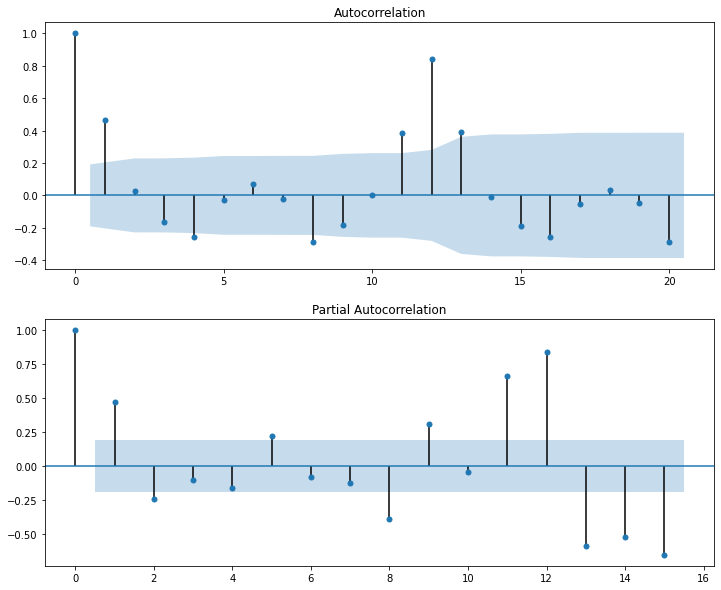

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax= plt.subplots(2, figsize=(12,10))
ax[0]=plot_acf(df['Sales'],ax=ax[0],lags=20)
ax[1]=plot_pacf(df['Sales'],ax=ax[1],lags=15)

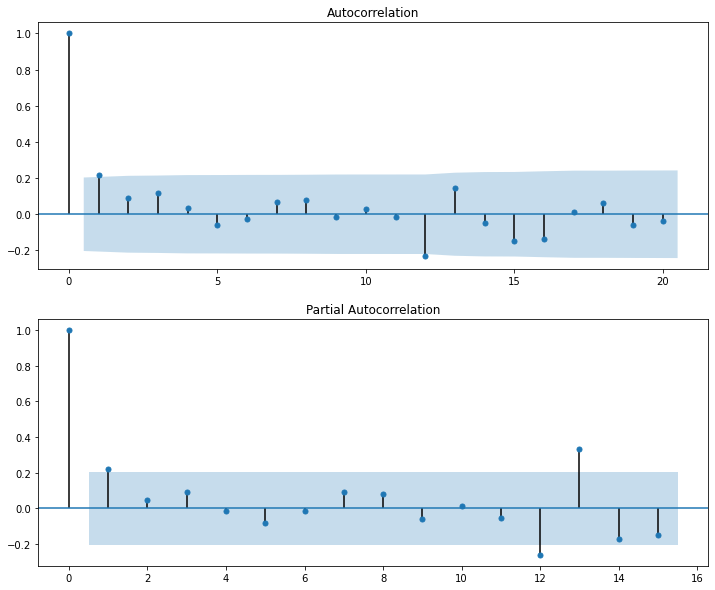

In [11]:
fig, ax= plt.subplots(2, figsize=(12,10))
ax[0]=plot_acf(df['Seasonal fist Diff'].dropna(),ax=ax[0],lags=20)
ax[1]=plot_pacf(df['Seasonal fist Diff'].dropna(),ax=ax[1],lags=15)

In [12]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [15]:
# ###------------------100% working -----------------------------------------------------
# # The best way to choose best p,d, q values by running loop for Non-Seasonal dataset
# p_values =range(0,2)
# d_values= range(0,2)
# q_values= range(0,2)

# import warnings
# warnings.filterwarnings('ignore')

# for p in p_values:
#     for d in d_values:
#         for q in q_values:
#             order=(p,d,q)
#             predictions=list()
         
#             for i in range(len(df)):
#                 try:
#                     model= ARIMA(df['Sales'],order)
#                     model_fit= model.fit(disp=0)
#                     pred_y= model_fit.forecast()[0]
#                     predictions.append(pred_y)
#                     error= np.sqrt(mean_squared_error(df['Sales'],predictions))
                    
#                     print("ARIMA %s RMSE = %.2f" %(order, error))
#                 except:
#                     continue            
            

ARIMA (0, 0, 1) RMSE = 3130.30
ARIMA (0, 1, 1) RMSE = 2558.45
ARIMA (1, 0, 0) RMSE = 2592.26
ARIMA (1, 0, 1) RMSE = 3060.82
ARIMA (1, 1, 0) RMSE = 2646.32
ARIMA (1, 1, 1) RMSE = 2792.02


In [66]:
# Best way to choose the best AIC  values by running loop for Non-Seasonal dataset

import itertools
import warnings
warnings.filterwarnings('ignore')

p=d=q=range(0,3)

pdq=list(itertools.product(p,d,q))

pred_list=list()
aic_list=list()
order_list=list()

for pm in pdq:
    
    try:
        model= ARIMA(df['Sales'],order=pm)
        model_fit= model.fit()
        pred_y= model_fit.forecast()[0]
        AIC= model_fit.aic
        order_list.append(pm)
        pred_list.append(pred_y)
        aic_list.append(AIC)
        print("ARIMA %s AIC = %.2f" %(pm, AIC))
        
    except:
        continue 
        
df_aic= pd.DataFrame(list(zip(order_list,pred_list,aic_list)),columns=['Order','Prediction','AIC'])        

ARIMA (0, 0, 1) AIC = 1918.72
ARIMA (0, 0, 2) AIC = 1920.03
ARIMA (0, 1, 1) AIC = 1937.85
ARIMA (0, 1, 2) AIC = 1902.88
ARIMA (0, 2, 1) AIC = 1926.77
ARIMA (0, 2, 2) AIC = 1927.35
ARIMA (1, 0, 0) AIC = 1925.22
ARIMA (1, 0, 1) AIC = 1919.48
ARIMA (1, 0, 2) AIC = 1922.71
ARIMA (1, 1, 0) AIC = 1938.88
ARIMA (1, 1, 1) AIC = 1910.25
ARIMA (1, 1, 2) AIC = 1902.99
ARIMA (1, 2, 0) AIC = 1980.44
ARIMA (1, 2, 1) AIC = 1928.09
ARIMA (1, 2, 2) AIC = 1902.71
ARIMA (2, 0, 0) AIC = 1920.90
ARIMA (2, 0, 1) AIC = 1921.34
ARIMA (2, 0, 2) AIC = 1901.30
ARIMA (2, 1, 0) AIC = 1934.70
ARIMA (2, 1, 1) AIC = 1904.12
ARIMA (2, 1, 2) AIC = 1903.47
ARIMA (2, 2, 0) AIC = 1966.21
ARIMA (2, 2, 1) AIC = 1924.38
ARIMA (2, 2, 2) AIC = 1921.92


In [70]:
df_aic.sort_values(by='AIC',ascending=True)[:5]

,Order,Prediction,AIC
17,"(2, 0, 2)",[5992.24927632893],1901.299483
14,"(1, 2, 2)",[5355.127706747171],1902.705471
3,"(0, 1, 2)",[7278.245519810334],1902.881549
11,"(1, 1, 2)",[7223.995166830891],1902.992646
20,"(2, 1, 2)",[6855.8513852949845],1903.466335


In [78]:
###For non-seasonal data

from statsmodels.tsa.arima_model import ARIMA

model= ARIMA(df['Sales'], order=(2,0,2))
model_fit= model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                     ARMA(2, 2)   Log Likelihood                -944.650
Method:                       css-mle   S.D. of innovations           1887.708
Date:                Fri, 11 Dec 2020   AIC                           1901.299
Time:                        15:45:11   BIC                           1917.223
Sample:                    01-01-1964   HQIC                          1907.752
                         - 09-01-1972                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4801.2377    249.763     19.223      0.000    4311.712    5290.763
ar.L1.Sales     0.9548      0.045     21.064      0.000       0.866       1.044
ar.L2.Sales    -0.9181      0.045    -20.503      0.000      -1.006      -0.830
ma.L1.Sales    -0.6938      0.054    -12.964      0.000      -0.799      -0.589
ma.L2.Sales     1.0000      0.039     25.352      0.000       0.923       1.077
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5200           -0.9049j            1.0437           -0.1670
AR.2            0.5200           +0.9049j            1.0437            0.1670
MA.1            0.3469           -0.9379j            1.0000           -0.1936
MA.2            0.3469           +0.9379j            1.0000            0.1936
-----------------------------------------------------------------------------
"""

In [79]:
model_fit.aic

1901.299483138197

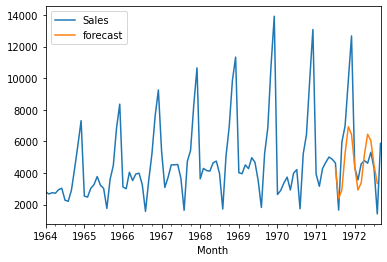

In [87]:
df['forecast']= model_fit.predict(start=90, end=103,typ='levels' ,dynamic=True)
df[['Sales','forecast']].plot()

We applied simple arima model on seasonal data thats why we get so dirty predicted values as you can see in the above graph 

### Now find the best fitted SARIMAX model to the given dataset

In [89]:
#---------------100% working---------------------------------------------------------------------

import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')

p=d=q=range(0,3)

pdq=list(itertools.product(p,d,q))
seasonal_pdq =[(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]


metric_aic_dic=dict()   # Here we are storing our AICs result  one by one

for pm in pdq:
    for pm_seasonal in seasonal_pdq:
        
        try:
            model= sm.tsa.statespace.SARIMAX(df['Sales'], order=pm, seasonal_order=pm_seasonal)
            model_aic= model.fit()
            print('ARIMA {} x {}x12 - AIC :{}'.format(pm, pm_seasonal, model_aic.aic))
            metric_aic_dic.update({(pm,pm_seasonal):model_aic.aic})
        except: 
            continue  
            
### Conveting AICs dict values into datafram and then sorting its values, in order to find minimum AIC
aic_df=pd.DataFrame({'(p,d,q)x(p,d,q,12)':metric_aic_dic.keys(), 'AIC':metric_aic_dic.values()})            

ARIMA (0, 0, 0) x (0, 0, 0, 12)x12 - AIC :2104.630040988431
ARIMA (0, 0, 0) x (0, 0, 1, 12)x12 - AIC :2002.4576294521428
ARIMA (0, 0, 0) x (0, 0, 2, 12)x12 - AIC :1933.8624119220494
ARIMA (0, 0, 0) x (0, 1, 0, 12)x12 - AIC :1511.2713844075613
ARIMA (0, 0, 0) x (0, 1, 1, 12)x12 - AIC :1513.16200673432
ARIMA (0, 0, 0) x (0, 1, 2, 12)x12 - AIC :1510.18253244019
ARIMA (0, 0, 0) x (0, 2, 0, 12)x12 - AIC :1386.7282636240495
ARIMA (0, 0, 0) x (0, 2, 1, 12)x12 - AIC :1344.3404105070592
ARIMA (0, 0, 0) x (0, 2, 2, 12)x12 - AIC :1344.7412026348688
ARIMA (0, 0, 0) x (1, 0, 0, 12)x12 - AIC :1752.330621126934
ARIMA (0, 0, 0) x (1, 0, 1, 12)x12 - AIC :1753.9207341078852
ARIMA (0, 0, 0) x (1, 0, 2, 12)x12 - AIC :1753.463598979995
ARIMA (0, 0, 0) x (1, 1, 0, 12)x12 - AIC :1513.1966895175885
ARIMA (0, 0, 0) x (1, 1, 1, 12)x12 - AIC :1507.4324671798256
ARIMA (0, 0, 0) x (1, 1, 2, 12)x12 - AIC :1547.0304131852113
ARIMA (0, 0, 0) x (1, 2, 0, 12)x12 - AIC :1355.469195070541
ARIMA (0, 0, 0) x (1, 2, 1, 12)x

ARIMA (0, 1, 2) x (0, 1, 1, 12)x12 - AIC :1486.2216571134659
ARIMA (0, 1, 2) x (0, 1, 2, 12)x12 - AIC :1486.7748855702084
ARIMA (0, 1, 2) x (0, 2, 0, 12)x12 - AIC :1377.5172501686923
ARIMA (0, 1, 2) x (0, 2, 1, 12)x12 - AIC :1321.7259632324551
ARIMA (0, 1, 2) x (0, 2, 2, 12)x12 - AIC :1313.3180292502298
ARIMA (0, 1, 2) x (1, 0, 0, 12)x12 - AIC :1824.3064603209396
ARIMA (0, 1, 2) x (1, 0, 1, 12)x12 - AIC :1730.042109112315
ARIMA (0, 1, 2) x (1, 0, 2, 12)x12 - AIC :1729.9990260907514
ARIMA (0, 1, 2) x (1, 1, 0, 12)x12 - AIC :1485.2244132110734
ARIMA (0, 1, 2) x (1, 1, 1, 12)x12 - AIC :1486.841052664051
ARIMA (0, 1, 2) x (1, 1, 2, 12)x12 - AIC :1483.9968147551779
ARIMA (0, 1, 2) x (1, 2, 0, 12)x12 - AIC :1338.1800171759132
ARIMA (0, 1, 2) x (1, 2, 1, 12)x12 - AIC :1317.2294160819738
ARIMA (0, 1, 2) x (1, 2, 2, 12)x12 - AIC :1313.1304919924721
ARIMA (0, 1, 2) x (2, 0, 1, 12)x12 - AIC :1737.7777344588958
ARIMA (0, 1, 2) x (2, 1, 0, 12)x12 - AIC :1486.7555547959366
ARIMA (0, 1, 2) x (2, 1, 1

ARIMA (1, 0, 1) x (1, 0, 0, 12)x12 - AIC :1727.6544120298558
ARIMA (1, 0, 1) x (1, 0, 1, 12)x12 - AIC :1726.3579708515572
ARIMA (1, 0, 1) x (1, 0, 2, 12)x12 - AIC :1799.9037775965035
ARIMA (1, 0, 1) x (1, 1, 0, 12)x12 - AIC :1499.0345604239883
ARIMA (1, 0, 1) x (1, 1, 1, 12)x12 - AIC :1500.9862030213317
ARIMA (1, 0, 1) x (1, 1, 2, 12)x12 - AIC :1500.51187634872
ARIMA (1, 0, 1) x (1, 2, 0, 12)x12 - AIC :1359.46949979165
ARIMA (1, 0, 1) x (1, 2, 1, 12)x12 - AIC :1334.9212831440018
ARIMA (1, 0, 1) x (1, 2, 2, 12)x12 - AIC :1341.1033933257024
ARIMA (1, 0, 1) x (2, 0, 0, 12)x12 - AIC :1724.584285677825
ARIMA (1, 0, 1) x (2, 0, 2, 12)x12 - AIC :1741.7316510828316
ARIMA (1, 0, 1) x (2, 1, 0, 12)x12 - AIC :1500.9623624945311
ARIMA (1, 0, 1) x (2, 1, 1, 12)x12 - AIC :1502.215382591007
ARIMA (1, 0, 1) x (2, 1, 2, 12)x12 - AIC :1499.1479512769204
ARIMA (1, 0, 1) x (2, 2, 0, 12)x12 - AIC :1348.1482725469207
ARIMA (1, 0, 1) x (2, 2, 1, 12)x12 - AIC :1333.6372510131202
ARIMA (1, 0, 1) x (2, 2, 2, 12

ARIMA (1, 2, 0) x (1, 1, 2, 12)x12 - AIC :1555.0397932745332
ARIMA (1, 2, 0) x (1, 2, 0, 12)x12 - AIC :1403.569046662283
ARIMA (1, 2, 0) x (1, 2, 1, 12)x12 - AIC :1374.4768463491957
ARIMA (1, 2, 0) x (1, 2, 2, 12)x12 - AIC :1365.3616706042526
ARIMA (1, 2, 0) x (2, 0, 0, 12)x12 - AIC :1807.151658520645
ARIMA (1, 2, 0) x (2, 0, 1, 12)x12 - AIC :1816.0803854085457
ARIMA (1, 2, 0) x (2, 1, 0, 12)x12 - AIC :1564.3172410342606
ARIMA (1, 2, 0) x (2, 1, 1, 12)x12 - AIC :1562.999387454198
ARIMA (1, 2, 0) x (2, 1, 2, 12)x12 - AIC :1554.6981139757331
ARIMA (1, 2, 0) x (2, 2, 0, 12)x12 - AIC :1392.8008099587366
ARIMA (1, 2, 0) x (2, 2, 1, 12)x12 - AIC :1371.1473420546233
ARIMA (1, 2, 0) x (2, 2, 2, 12)x12 - AIC :1364.5619949902784
ARIMA (1, 2, 1) x (0, 0, 0, 12)x12 - AIC :1925.3158960908906
ARIMA (1, 2, 1) x (0, 0, 1, 12)x12 - AIC :1853.5684364743456
ARIMA (1, 2, 1) x (0, 0, 2, 12)x12 - AIC :1804.3630321843002
ARIMA (1, 2, 1) x (0, 1, 0, 12)x12 - AIC :1508.7145428720762
ARIMA (1, 2, 1) x (0, 1, 1,

ARIMA (2, 0, 2) x (2, 1, 2, 12)x12 - AIC :1502.6040158410588
ARIMA (2, 0, 2) x (2, 2, 0, 12)x12 - AIC :1351.1489587136325
ARIMA (2, 0, 2) x (2, 2, 1, 12)x12 - AIC :1336.8257064086445
ARIMA (2, 0, 2) x (2, 2, 2, 12)x12 - AIC :1347.239424454404
ARIMA (2, 1, 0) x (0, 0, 0, 12)x12 - AIC :1932.7369942269029
ARIMA (2, 1, 0) x (0, 0, 1, 12)x12 - AIC :1861.4760672969117
ARIMA (2, 1, 0) x (0, 0, 2, 12)x12 - AIC :1813.5986231977263
ARIMA (2, 1, 0) x (0, 1, 0, 12)x12 - AIC :1503.0919420007854
ARIMA (2, 1, 0) x (0, 1, 1, 12)x12 - AIC :1500.8751791135965
ARIMA (2, 1, 0) x (0, 1, 2, 12)x12 - AIC :1502.1619772174095
ARIMA (2, 1, 0) x (0, 2, 0, 12)x12 - AIC :1387.7331071814374
ARIMA (2, 1, 0) x (0, 2, 1, 12)x12 - AIC :1332.5078876770058
ARIMA (2, 1, 0) x (0, 2, 2, 12)x12 - AIC :1325.1749351651015
ARIMA (2, 1, 0) x (1, 0, 0, 12)x12 - AIC :1750.6677842366012
ARIMA (2, 1, 0) x (1, 0, 1, 12)x12 - AIC :1749.7305310512843
ARIMA (2, 1, 0) x (1, 0, 2, 12)x12 - AIC :1750.2451416559968
ARIMA (2, 1, 0) x (1, 1, 

ARIMA (2, 2, 2) x (0, 0, 2, 12)x12 - AIC :1808.1281432603005
ARIMA (2, 2, 2) x (0, 1, 0, 12)x12 - AIC :1491.4655017585135
ARIMA (2, 2, 2) x (0, 1, 1, 12)x12 - AIC :1488.8554837470135
ARIMA (2, 2, 2) x (0, 1, 2, 12)x12 - AIC :1489.7943753722407
ARIMA (2, 2, 2) x (0, 2, 0, 12)x12 - AIC :1376.1820192586654
ARIMA (2, 2, 2) x (0, 2, 1, 12)x12 - AIC :1321.0298981294222
ARIMA (2, 2, 2) x (0, 2, 2, 12)x12 - AIC :1312.0509206110337
ARIMA (2, 2, 2) x (1, 0, 0, 12)x12 - AIC :1743.023622413553
ARIMA (2, 2, 2) x (1, 0, 1, 12)x12 - AIC :1745.7819978395908
ARIMA (2, 2, 2) x (1, 1, 0, 12)x12 - AIC :1488.0146619181253
ARIMA (2, 2, 2) x (1, 1, 1, 12)x12 - AIC :1493.4436386677053
ARIMA (2, 2, 2) x (1, 1, 2, 12)x12 - AIC :1498.3613398504392
ARIMA (2, 2, 2) x (1, 2, 0, 12)x12 - AIC :1337.8089774327254
ARIMA (2, 2, 2) x (1, 2, 1, 12)x12 - AIC :1315.595953945138
ARIMA (2, 2, 2) x (1, 2, 2, 12)x12 - AIC :1315.7806880419407
ARIMA (2, 2, 2) x (2, 0, 0, 12)x12 - AIC :1739.3810677387917
ARIMA (2, 2, 2) x (2, 1, 0

In [90]:
### Conveting AICs dict values into datafram and then sorting its values, in order to find minimum AIC
aic_df=pd.DataFrame({'(p,d,q)x(p,d,q,12)':metric_aic_dic.keys(), 'AIC':metric_aic_dic.values()})            

In [92]:

aic_df.sort_values(by='AIC')[:5]

,"(p,d,q)x(p,d,q,12)",AIC
451,"((1, 2, 2), (0, 2, 2, 12))",1306.995954
458,"((1, 2, 2), (1, 2, 2, 12))",1309.445260
216,"((0, 2, 2), (0, 2, 2, 12))",1311.396104
681,"((2, 2, 2), (0, 2, 2, 12))",1312.050921
233,"((0, 2, 2), (2, 2, 2, 12))",1312.201731


In [ ]:
###-WE can also find the optimum value of p,d,q by applying auto-arima method

from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(df['Sales'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series like if we are taking seasonal then m=12
                      d=None,           # let model determine 'd'
                      seasonal=True,   #  Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
model_autoARIMA.summary()

##------Before moving forward, let’s review the residual plots from auto ARIMA.
### model_autoARIMA.plot_diagnostics(figsize=(15,8))
###plt.show()

In [93]:
# After running loop we get (1,2,2)x(0,2,2,12) for optimum forcasting
import statsmodels.api as sm

model1= sm.tsa.statespace.SARIMAX(df['Sales'],order=(1,2,2)\
                                 , seasonal_order=(0,2,2,12))
results1= model1.fit()


# After running auto ARIMA we get (1,0,0)x(1,0,0,12) for forcasting

model2= sm.tsa.statespace.SARIMAX(df['Sales'],order=(1,0,0)\
                                 , seasonal_order=(1,0,0,12))
results2= model2.fit()




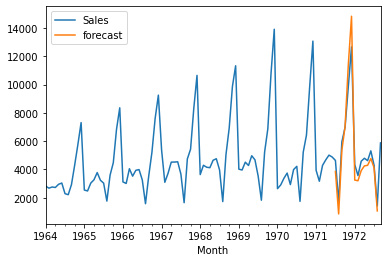

In [94]:
# Forcasting Mannual Model
df['forecast']= results1.predict(start=90,end=103, dynamic=True)
df[['Sales','forecast']].plot()

In [ ]:
# Forcasting Auto Arima Model
df['forecast']= results2.predict(start=90,end=103, dynamic=True)
df[['Sales','forecast']].plot()

In [95]:
# Now we are gonna predict future value by adding some new date

from pandas.tseries.offsets import DateOffset

future_dates= [df.index[-1]+DateOffset(months=x) for x in range(0,24)]

In [96]:
future_dates_df= pd.DataFrame(index=future_dates[1:],columns=df.columns )

In [97]:
future_df= pd.concat([df, future_dates_df])

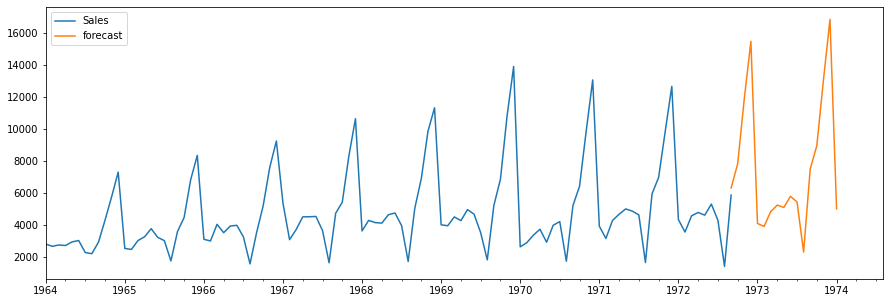

In [99]:
future_df['forecast']=results1.predict(start=104, end=120, dynamic=True)
future_df[['Sales','forecast']].plot(figsize=(15,5))

In [4]:
!jt -h

usage: jt [-h] [-l] [-t THEME] [-f MONOFONT] [-fs MONOSIZE] [-nf NBFONT]
          [-nfs NBFONTSIZE] [-tf TCFONT] [-tfs TCFONTSIZE] [-dfs DFFONTSIZE]
          [-ofs OUTFONTSIZE] [-mathfs MATHFONTSIZE] [-m MARGINS]
          [-cursw CURSORWIDTH] [-cursc CURSORCOLOR] [-cellw CELLWIDTH]
          [-lineh LINEHEIGHT] [-altp] [-altmd] [-altout] [-P] [-T] [-N] [-kl]
          [-vim] [-r] [-dfonts]

optional arguments:
  -h, --help            show this help message and exit
  -l, --list            list available themes
  -t THEME, --theme THEME
                        theme name to install
  -f MONOFONT, --monofont MONOFONT
                        monospace code font
  -fs MONOSIZE, --monosize MONOSIZE
                        code font-size
  -nf NBFONT, --nbfont NBFONT
                        notebook font
  -nfs NBFONTSIZE, --nbfontsize NBFONTSIZE
                        notebook fontsize
  -tf TCFONT, --tcfont TCFONT
                        txtcell font
  -tfs TCFONTSIZE, --tcfontsize TCF

# Stock Price Prediction using Rolling ARIMA model

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
import yfinance as yf 

In [9]:
# df=web.DataReader('AAPL',data_source='yahoo',start='2014-08-19', end='2020-06-22')
data = yf.download('AAPL', start = '2012-01-01', end='2017-01-01')

[*********************100%***********************]  1 of 1 completed


In [57]:
net_df= data.copy()
net_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449691,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516598,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655558,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787850,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767572,394024400
...,...,...,...,...,...,...
2016-12-23,28.897499,29.129999,28.897499,29.129999,27.109791,56998000
2016-12-27,29.129999,29.450001,29.122499,29.315001,27.281961,73187600
2016-12-28,29.379999,29.504999,29.049999,29.190001,27.165627,83623600


In [23]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [17]:
train_data, test_data = net_df[0:int(len(net_df)*0.9)], net_df[int(len(net_df)*0.9):]

train_arima = train_data['Open']
test_arima = test_data['Open']


history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit()
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])

In [18]:
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)

In [19]:
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 0.12870306755153574
MAE: 0.24097356545176357
RMSE: 0.35875209762667


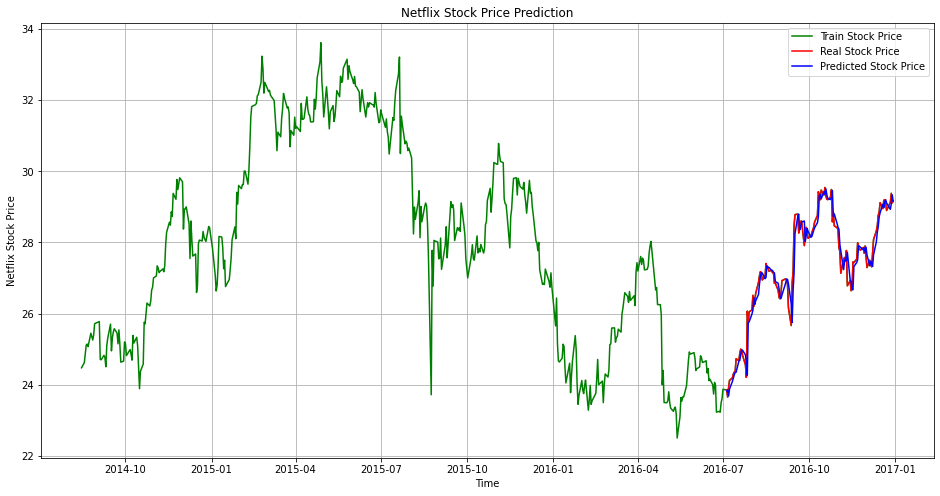

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(net_df.index[-600:], net_df['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Netflix Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()